In [1]:
%%capture
import sys
import glob, os
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi
import smt_modules.tools as tools

import pandas as pd
import netCDF4 as nc
import xarray as xr    
from dask.diagnostics import ProgressBar
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload
import matplotlib.patches as patches
from matplotlib import colors

In [27]:
lon_reg_R1_f = [-63.7,-61.4]
lat_reg_R1_f = [34.9,35.4]
lon_reg_R2_f = [-65.7,-63.6]
lat_reg_R2_f = [33.8,34.2]
lon_reg_R3_f = [-62.7,-60.6]
lat_reg_R3_f = [32.7,33.1]
lon_reg_R4_f = [-76.6,-74.6]
lat_reg_R4_f = [26.7,27.3]
lon_reg_R5_f = [-60.5,-58.9]
lat_reg_R5_f = [35.4,35.8]

lon_reg_R6_f  = [-63.25,-61]
lat_reg_R6_f  = [36.5, 37]
lon_reg_R7_f  = [-58.4,-57,2]
lat_reg_R7_f  = [29.6,30]
lon_reg_R8_f  = [-62.7,-60.6]
lat_reg_R8_f  = [28.4, 28.9]
lon_reg_R9_f  = [-68.3,-65.5]
lat_reg_R9_f  = [30.9,31.4]
lon_reg_R10_f = [-70.9,-69.5]
lat_reg_R10_f = [29.8,30.2]
lon_reg_R11_f = [-69.9,-68.3]
lat_reg_R11_f = [29.3,29.7]
lon_reg_R12_f  = [-64.7, -63.3]
lat_reg_R12_f  = [31.4, 31.9]

In [4]:
#Reload modules:
reload(eva)
reload(tools)

Load my smt functions


<module 'smt_modules.tools' from '/home/m/m300878/submesoscaletelescope/smt_modules/tools.py'>

In [5]:
lon_reg_R0 = [-72.5, -55]
lat_reg_R0 = [32, 42]
lon_reg_R0 = [-80.5, -55]
lat_reg_R0 = [25, 40]

fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
fig_path = '/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/front/poster/'
calcname = 'small_33_34'
lon_reg = lon_reg_R0
lat_reg = lat_reg_R0
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

## load data

In [6]:
#load
tt = 792
tt_recalc = 2

t = eva.load_smt_T()
s = eva.load_smt_S()
b = eva.load_smt_b()
n = eva.load_smt_N2()
w = eva.load_smt_w()

t_tsel      = t.isel(time=tt)
s_tsel      = s.isel(time=tt)
dbdx_tsel   = b.dbdx.isel(time=tt_recalc)
dbdy_tsel   = b.dbdy.isel(time=tt_recalc)
n_tsel      = n.N2.isel(time=tt_recalc)
w_tsel      = w.isel(time=tt_recalc)
b_tsel      = b.b.isel(time=tt_recalc)
wb_tsel     = w_tsel*b_tsel

# path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb{time_averaged}_prime.nc'
# wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
# wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')

#interpolate
data_t_mean      = pyic.interp_to_rectgrid_xr(t_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_s_mean      = pyic.interp_to_rectgrid_xr(s_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_w_mean     = pyic.interp_to_rectgrid_xr(w_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_b_mean     = pyic.interp_to_rectgrid_xr(b_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_wb_mean     = pyic.interp_to_rectgrid_xr(wb_tsel, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

# data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week


#calculate
#mld
data_rho_mean = gsw.rho(data_s_mean, data_t_mean, depthc[2])
mld_monte, mask_monte, mldx_monte = eva.calc_mld_montegut_xr(data_rho_mean, depthc)
mld, mask, mldx = eva.calc_mld_xr(data_rho_mean, depthc)
mld_mask = mask.transpose('depthc', 'lat', 'lon')
mld_mask = mld_mask.rename(depthc='depthi') #TODO

wb_dselect = data_wb_mean.sel(depthi=slice(depthi[0], depthi[111]))
w_dselect = data_w_mean.sel(depthi=slice(depthi[0], depthi[111]))
b_dselect = data_b_mean.sel(depthi=slice(depthi[0], depthi[111]))

#ri
data_M2_mean  = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))
data_M2_ymean = data_dbdy_mean.sel(depthi=slice(depthi[0], depthi[111]))
data_M2_xmean = data_dbdx_mean.sel(depthi=slice(depthi[0], depthi[111]))
ri_mean = eva.calc_richardsonnumber(data_n2_mean.lat, data_n2_mean, data_M2_ymean)

#Average over mld M2, Ri, wb
M2_dselect  = data_M2_mean.sel(depthi=slice(depthi[0], depthi[111]))
M2x_dselect = data_M2_xmean.sel(depthi=slice(depthi[0], depthi[111]))
M2y_dselect = data_M2_ymean.sel(depthi=slice(depthi[0], depthi[111]))

M2x_mld = M2x_dselect  * mld_mask.data
M2x_mld = M2x_mld.where(M2x_mld !=0) #zeros to nans
M2x_mld_mean = M2x_mld.mean(dim='depthi', skipna=True)

M2y_mld = M2y_dselect  * mld_mask.data
M2y_mld = M2y_mld.where(M2y_mld !=0) #zeros to nans
M2y_mld_mean = M2y_mld.mean(dim='depthi', skipna=True)

M2_mld = M2_dselect  * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0) #zeros to nans
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)

n2_mld = data_n2_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
n2_mld = n2_mld.where(n2_mld !=0) #zeros to nans

ri_dselect = ri_mean.sel(depthi=slice(depthi[0], depthi[111])) #ri_mean[:112]
ri_mld = ri_dselect * mld_mask.data #Todo. check if error to big because mld mask is on depthc
ri_mld = ri_mld.where(ri_mld != 0) #zeros to nans
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)


# wb_dselect = data_wb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) 
# wb_mld = wb_dselect * mld_mask.data
# wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
# wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)

In [7]:
argo = eva.load_argo_climatology()

In [8]:
def calc_front_varaibles(wb, w, b, ri, mldx, mldx_monte, m2x, m2y, rho, n2, lon, lat, dim=None, ave=False):
    """calculate lhs and rhs and other variables of the front above mld"""
    # if ave == False:
    #     wb      = wb.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     ri      = ri.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     mldx  = mldx.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     mldx_monte  = mldx_monte.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     m2x    = m2x.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     m2y    = m2y.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     rho    = rho.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     n2      = n2.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1]))
    #     f       = calc_coriolis_parameter(m2y.lat)

    if ave == True:
        wb      = wb.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        w      = w.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        b      = b.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        ri      = ri.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        mldx    = mldx.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        mldx_monte  = mldx_monte.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        m2x      = m2x.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        m2y      = m2y.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        rho     = rho.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        n2      = n2.sel(lon=slice(lon[0], lon[1])).sel( lat=slice(lat[0], lat[1])).mean(dim=dim, skipna=True)
        if dim == 'lat': f = eva.calc_coriolis_parameter((lat[1]-lat[0])/2+lat[0])
        else: f = eva.calc_coriolis_parameter(m2y.lat)
        wb_prime = wb - w*b
  
    alpha = eva.calc_alpha(m2y, f)
    lhs = eva.calc_lhs_wb(wb_prime, mldx, f, alpha)
    return wb_prime, ri, mldx, mldx_monte, m2x, m2y, alpha, lhs, rho, n2

In [11]:

def eval_front(lon_front, lat_front, front):
    ylim =500,0

    lat_mean = eva.mean_help(lat_front)
    lon_mean = eva.mean_help(lon_front)
    argo_mld = argo.mld_da_mean.isel(iLAT=int(lat_mean), iLON=int(lon_mean), iMONTH=3)

    #plot vertical profiles
    M2y_masked = M2y_dselect.where(M2y_dselect < -1e-9, np.nan)
    wb_fselect, ri_fselect, mldx_fselect, mldx_monte_fselect, m2x_fselect, m2y_fselect, alpha_fselect, lhs_fselect, rho_fselect, n2_fselect = calc_front_varaibles(wb_dselect.w, w_dselect.w, b_dselect, ri_dselect, mldx, mldx_monte, M2x_dselect, M2y_masked, data_rho_mean, data_n2_mean, lon_front, lat_front, dim='lon', ave=True)
    eva.plot_front_profiles(rho_fselect, n2_fselect, m2x_fselect, m2y_fselect, ri_fselect, wb_fselect, mldx_fselect, mldx_monte_fselect, argo_mld, fig_path, front=f'Front_{front}', dim='lat')

    #calculate streamfunction:
    MLDX = mldx_fselect.data.mean()
    M2Ymin = np.nanmin(m2y_fselect.isel(depthi=slice(0,80)).mean(dim='lat').data)
    RImin = np.nanmin(ri_fselect.isel(depthi=slice(0,80)).data)

    psi_fox = eva.calc_psi_fox(lat_mean, MLDX, M2Ymin)
    print('psi_fox', psi_fox)
    psi_stone = eva.calc_psi_stone(lat_mean, MLDX, M2Ymin, RImin)
    print('psi_stone', psi_stone)



    M2y_masked = M2y_dselect.where(M2y_dselect < -5e-9, np.nan)
    # wb_fselect, ri_fselect, mldx_fselect, mldx_monte_fselect, m2x_fselect, m2y_fselect, alpha_fselect, lhs_fselect, rho_fselect, n2_fselect = eva.calc_front_varaibles(wb_dselect, ri_dselect, mldx, mldx_monte, M2x_dselect, M2y_masked, data_rho_mean, data_n2_mean, lon_front, lat_front, dim='lon', ave=True)
    path = f'{fig_path}_{front}_crossfront_slice_crossfront_ave_ag22.png'
    title = f"crossfront slice, alongfront averaged over mld of {front}"
    eva.plot_slice_front(x=alpha_fselect.lat, y=alpha_fselect.depthi, lhs=lhs_fselect, alpha=alpha_fselect, 
                    wb=wb_fselect, ri=ri_fselect, mldx=mldx_fselect, mldx_monte=mldx_monte_fselect, argo_mld=argo_mld, rho=rho_fselect, m2=m2y_fselect,
                    ylim=ylim, title=title, fig_path=path, savefig=True)



    #plot slope
    #here mld masked data is used
    # wb_fselect, ri_fselect, mldx_fselect, mldx_monte_fselect, m2x_fselect, m2y_fselect, alpha_fselect, lhs_fselect, rho_fselect, n2_fselect = eva.calc_front_varaibles(wb_mld, ri_mld, mldx, mldx_monte, M2x_mld, M2y_mld, data_rho_mean, n2_mld, lon_front, lat_front, dim='lon', ave=True)
    #  logx, logy = eva.calc_log10_for_slope(np.reshape(ri_fselect.data, ri_fselect.size), np.reshape(lhs_fselect.data, ri_fselect.size))
    # eva.plot_slope_log_wb_ri(logx, logy, figname=f'{front}_alongfront_average', fpath=fig_path, ylim=(-3,0), xlim=(0.5,5), savefig=True)

    #calculate mean values from diagnostic
    # n2_mean_diag = n2_fselect.mean(dim='lat') #* mld_mask.data
    # n2_mean_diag = n2_mean_diag.mean(dim='depthi', skipna=True)
    # n2_ninf = ~np.isinf(n2_fselect) * n2_fselect # remove inf
    # n2_mean_diag = n2_ninf.mean(dim='lat').mean() # average over mld base
    # m2_mean_diag = m2y_fselect.mean(dim='lat') #* mld_mask.data
    # m2_mean_diag = m2_mean_diag.mean(dim='depthi', skipna=True)
    # wb_mean_diag = wb_fselect.mean(dim='lat') #* mld_mask.data
    # wb_mean_diag = wb_mean_diag.mean(dim='depthi', skipna=True)

    # psi_mean_diag = - wb_mean_diag/m2_mean_diag

    # ri_diag = eva.calc_richardsonnumber(lat_mean, n2_mean_diag, m2_mean_diag)

    # print('Diagnostic values (mean over mld): n2', n2_mean_diag.data, 'm2', m2_mean_diag.data, 'ri', ri_diag.data, 'wb', wb_mean_diag.data, 'psi', psi_mean_diag.data)

Load my smt functions
MLD 459.0449456521739
psi_max mean mean 2.060407
lat_mean 35.0 H 459.0449456521739 M2 -5.1981818e-08
psi_fox -7.878176590413807
lat_mean 35.0 H 459.0449456521739 M2 -5.1981818e-08 Ri -inf
psi_stone nan


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


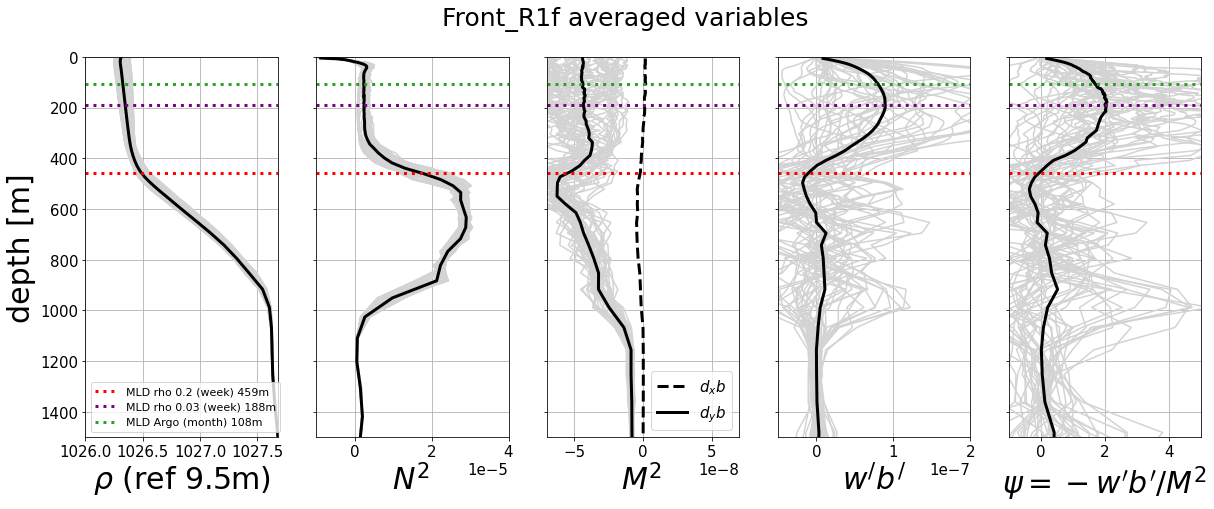

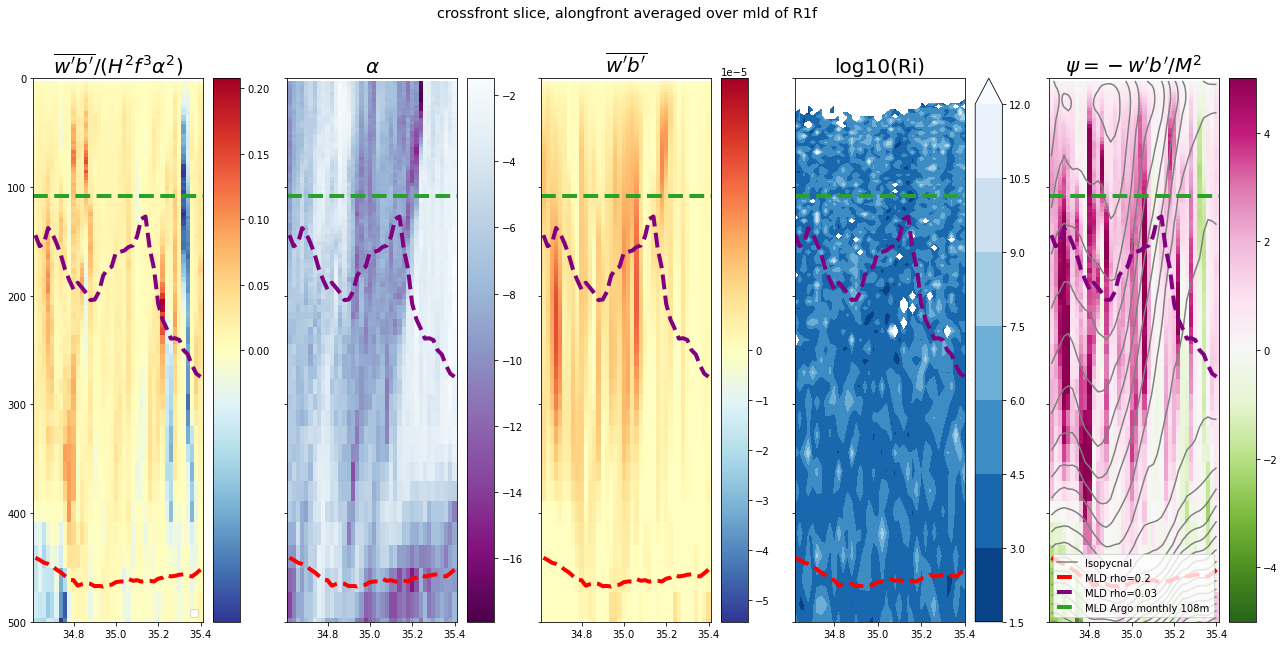

In [28]:
reload(eva)
front =            'R1f'
lon_front = lon_reg_R1_f
lat_front = lat_reg_R1_f

##plot slice sections
dl=0.3
# lat_front[1] = lat_front[1] + dl
lat_front[0] = lat_front[0] - dl

eval_front(lon_front , lat_front, front)

# front selection

In [68]:
def add_rectangles():
    fs = 22
    front='R5f'
    rect, right, top = eva.draw_rect(lat_reg_R5_f, lon_reg_R5_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R1f'
    rect, right, top = eva.draw_rect(lat_reg_R1_f, lon_reg_R1_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R2f'
    rect, right, top = eva.draw_rect(lat_reg_R2_f, lon_reg_R2_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R3f'
    rect, right, top = eva.draw_rect(lat_reg_R3_f, lon_reg_R3_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R4f'
    rect, right, top = eva.draw_rect(lat_reg_R4_f, lon_reg_R4_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R6f'
    rect, right, top = eva.draw_rect(lat_reg_R6_f, lon_reg_R6_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R7f'
    rect, right, top = eva.draw_rect(lat_reg_R7_f, lon_reg_R7_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R8f'
    rect, right, top = eva.draw_rect(lat_reg_R8_f, lon_reg_R8_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R9f'
    rect, right, top = eva.draw_rect(lat_reg_R9_f, lon_reg_R9_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R10f'
    rect, right, top = eva.draw_rect(lat_reg_R10_f, lon_reg_R10_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R11f'
    rect, right, top = eva.draw_rect(lat_reg_R11_f, lon_reg_R11_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)
    front='R12f'
    rect, right, top = eva.draw_rect(lat_reg_R12_f, lon_reg_R12_f,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'{front}', fontsize=fs)

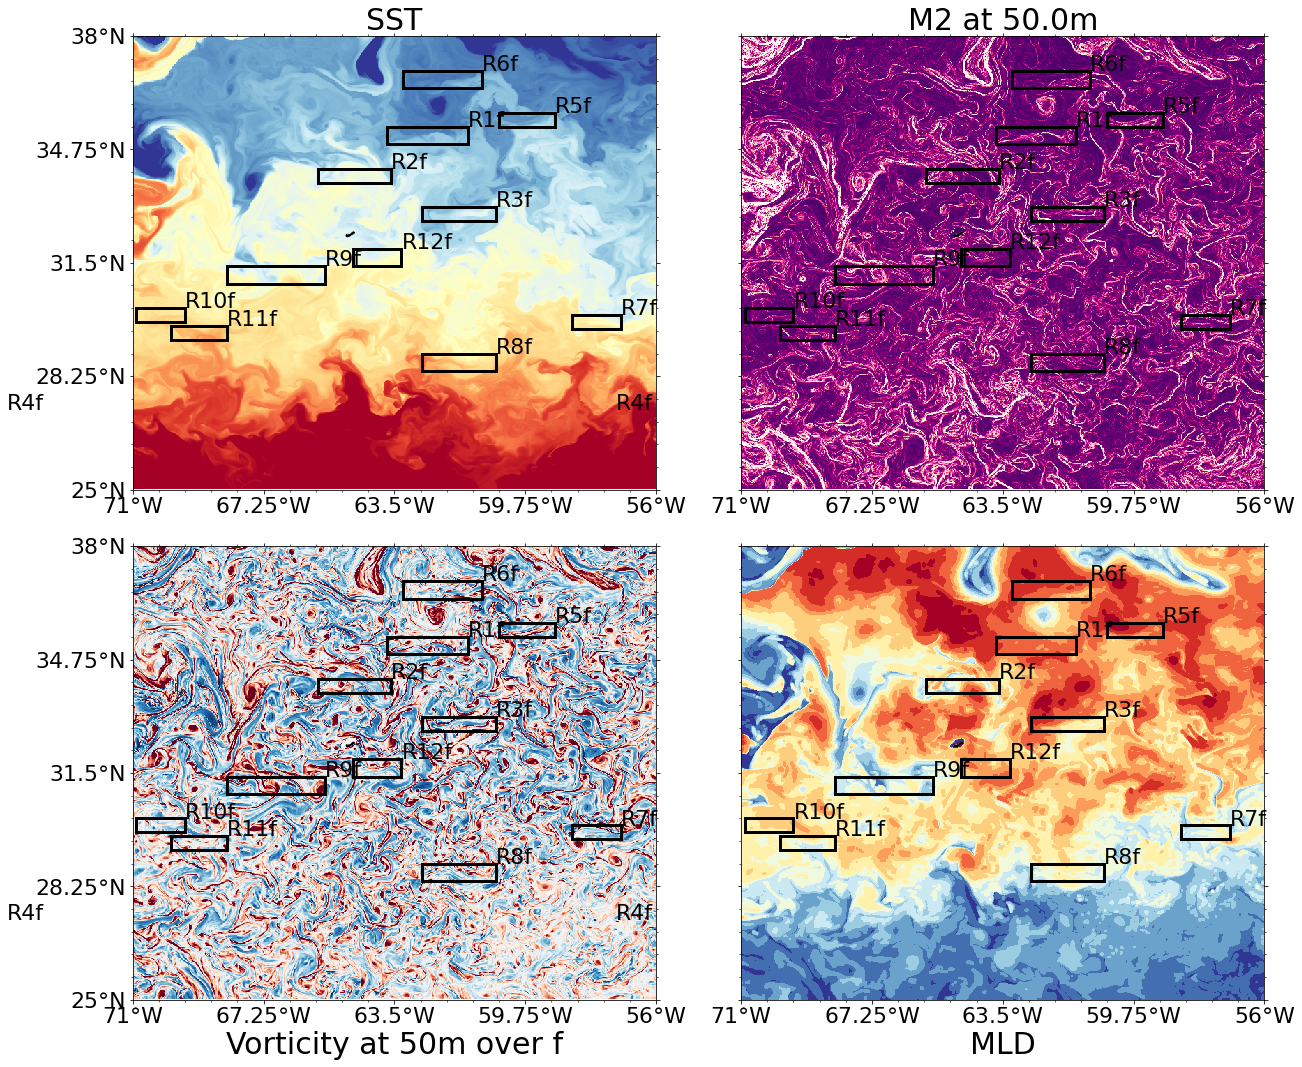

In [80]:
idepth = 16
lon = data_M2_mean.lon
lat = data_M2_mean.lat
lon_reg = -71,-56
lat_reg = 25,38
# lon_reg = -68,-58
# lat_reg = 30,38
fs=30
ls = 15


asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(2, 2, plot_cb=False, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=False, axlab_kw=None,  sharey=True, daxr=3)
# fig = plt.gcf()
# fig.suptitle('7 Day mean')
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 16.5,22
pyic.shade(lon, lat, data_t_mean.isel(depthc=0), ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdYlBu_r')
ax.set_title(f'SST', fontsize=fs)
add_rectangles()

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim=0,3e-7
pyic.shade(lon, lat, data_M2_mean.isel(depthi=idepth), ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdPu_r')
ax.set_title(f'M2 at {depthi[idepth]}m', fontsize=fs)
add_rectangles()

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim = 1
pyic.shade(lon, lat, vorticity, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False)
ax.set_xlabel(f'Vorticity at 50m over f', fontsize=fs)
add_rectangles()

ii+=1; ax=hca[ii]; cax=hcb[ii]
contfs = np.arange(50.,600.,50.)
clim = [contfs.min(), contfs.max()]
pyic.shade(lon, lat, mldx, ax=ax, cax=cax, clim=clim, contfs=contfs,  transform=ccrs_proj, rasterized=False)
ax.set_xlabel(f'MLD', fontsize=fs)
add_rectangles()

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 
    ax.tick_params(labelsize=22)
    # cax.tick_params(labelsize=15)

# plt.savefig(f'{fig_path}select_front_zoom_ag22.png', dpi=250, format='png', bbox_inches='tight')


In [49]:
vort = eva.load_smt_vorticity()


In [55]:
vort.time[545]

<xarray.DataArray 'time' ()>
array('2010-03-16T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-03-16T01:00:00

In [51]:
t.time[tt]

<xarray.DataArray 'time' ()>
array('2010-03-16T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-03-16T01:00:00

In [77]:

vort_mean_w = vort.isel(time=545)
vorticity = pyic.interp_to_rectgrid_xr(vort_mean_w.vort_f_cells_50m, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
